<a href="https://colab.research.google.com/github/rzunick/MNA-Navegacion-Autonoma-Equipo-14/blob/main/Proyecto_Final_Equipo_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

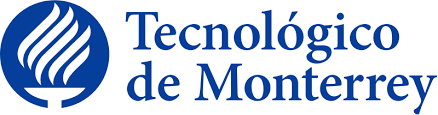

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Navegación autónoma**
## Profesor: David Antonio Torres
## Proyecto Final - Behavioral Cloning
## **Equipo 14**:
### - *Alejandro Juárez Corona-A01168444*
### - *Juan Carlos Lopez Cruz- A01793052*
### - *Ronald David Zúniga Sánchez-A01686240*
### - *Rodrigo López Aguilera-A01793071*

### **Importar Librerías**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import os
import ntpath

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.image as mpimg
from imgaug import augmenters as iaa

### Conexión con Github.

In [7]:
!git clone https://github.com/rzunick/MNA-Navegacion-Autonoma-Equipo-14.git

fatal: destination path 'MNA-Navegacion-Autonoma-Equipo-14' already exists and is not an empty directory.


### Preparación de Base de Datos

In [36]:
#Inicializamos carpeta de trabajo e importamos archivo csv

datadir = "/content/MNA-Navegacion-Autonoma-Equipo-14/data/udacity_sim/track_1"

columns = ['center', 'left', 'right', 'steering', 'throttle',
'reverse', 'speed']

data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)

pd.set_option('display.max_colwidth', -1)

data.head()

<ipython-input-36-6e329d289c24>:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\center_2023_06_19_22_04_58_723.jpg,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\left_2023_06_19_22_04_58_723.jpg,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\right_2023_06_19_22_04_58_723.jpg,0.0,1.0,0,6.762121
1,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\center_2023_06_19_22_04_58_792.jpg,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\left_2023_06_19_22_04_58_792.jpg,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\right_2023_06_19_22_04_58_792.jpg,0.0,1.0,0,7.674099
2,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\center_2023_06_19_22_04_58_864.jpg,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\left_2023_06_19_22_04_58_864.jpg,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\right_2023_06_19_22_04_58_864.jpg,0.0,1.0,0,8.353499
3,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\center_2023_06_19_22_04_58_937.jpg,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\left_2023_06_19_22_04_58_937.jpg,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\right_2023_06_19_22_04_58_937.jpg,-0.1,1.0,0,9.251003
4,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\center_2023_06_19_22_04_59_008.jpg,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\left_2023_06_19_22_04_59_008.jpg,C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\right_2023_06_19_22_04_59_008.jpg,-0.3,1.0,0,10.119220


In [37]:
# Depuración de datos para dejar solo el nombre del archivo unicamente

def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2023_06_19_22_04_58_723.jpg,left_2023_06_19_22_04_58_723.jpg,right_2023_06_19_22_04_58_723.jpg,0.0,1.0,0,6.762121
1,center_2023_06_19_22_04_58_792.jpg,left_2023_06_19_22_04_58_792.jpg,right_2023_06_19_22_04_58_792.jpg,0.0,1.0,0,7.674099
2,center_2023_06_19_22_04_58_864.jpg,left_2023_06_19_22_04_58_864.jpg,right_2023_06_19_22_04_58_864.jpg,0.0,1.0,0,8.353499
3,center_2023_06_19_22_04_58_937.jpg,left_2023_06_19_22_04_58_937.jpg,right_2023_06_19_22_04_58_937.jpg,-0.1,1.0,0,9.251003
4,center_2023_06_19_22_04_59_008.jpg,left_2023_06_19_22_04_59_008.jpg,right_2023_06_19_22_04_59_008.jpg,-0.3,1.0,0,10.119220


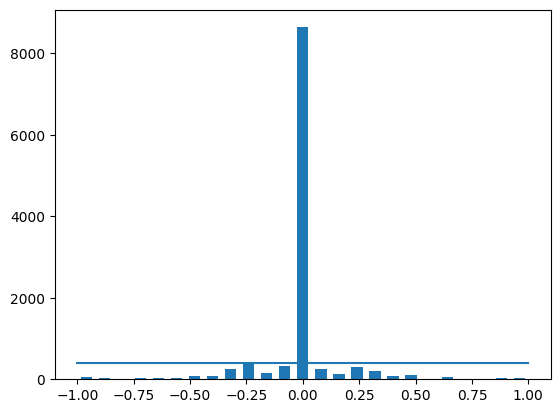

In [38]:
# Visualización de la base de datos para observar distribución

num_bins = 25
samples_per_bin = 400

hist, bins = np.histogram(data['steering'], num_bins)

center = (bins[:-1]+ bins[1:]) * 0.5

plt.bar(center, hist, width=0.05)

plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

Se observa que la base de datos tiene muchos más registros en "ángulo 0" los cuales corresponden a imágenes tomadas mientras el vehículo se trasladaba en línea recta.

Para obtener un dataset más equilibrado entre clases (ángulos para el manejo automático), es necesario truncar el número de datos máximo.

total data: 11269
removed: 8237
remaining: 3032


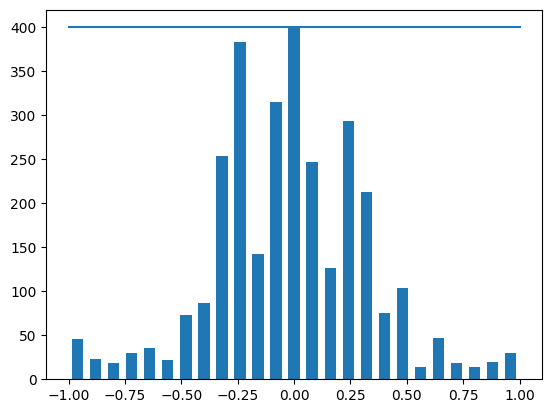

In [39]:
# Se depura el dataset utilizando el valor de la variable samples_per_bin para truncar el máximo de elementos por clase.

print('total data:', len(data))
remove_list = []

for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i]<= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))

plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [44]:
# Se imprime los datos ejemplo de uno de los datapoints
print(data.iloc[1])

# Se define función para cargar las imágenes en formato de np array en variable image_paths y se carga variable dependiente "steering" en df steerings.
def load_img_steering(datadir, df):
  image_path = []
  steering = []

  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))

    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)

    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2023_06_19_22_04_58_937.jpg
left        left_2023_06_19_22_04_58_937.jpg  
right       right_2023_06_19_22_04_58_937.jpg 
steering   -0.1                               
throttle    1.0                               
reverse     0                                 
speed       9.251003                          
Name: 3, dtype: object


In [46]:
# Se preparan los sub-conjuntos de entrenamiento y validación.
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples:{}'.format(len(X_train), len(X_valid)))

Training Samples: 7276
Valid Samples:1820


Text(0.5, 1.0, 'Validation set')

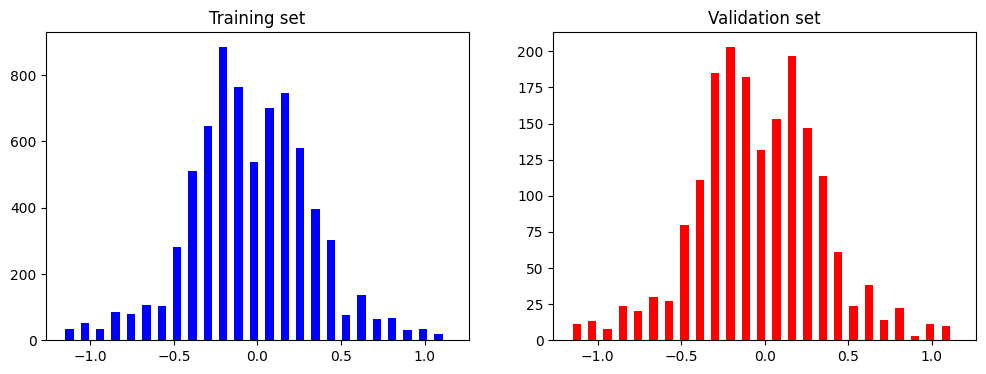

In [47]:
# Se visualizan las distribuciones de los sub-conjuntos de entrenamiento y validación.
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Se observa que se obtienen dos sub-conjuntos con clases balanceadas.

Se procede a revisar las imágenes importadas y realizar procesos de augmentación en caso de requerirse.

**Image Aumentation 1 - Zoom**

Text(0.5, 1.0, 'Zoomed Image')

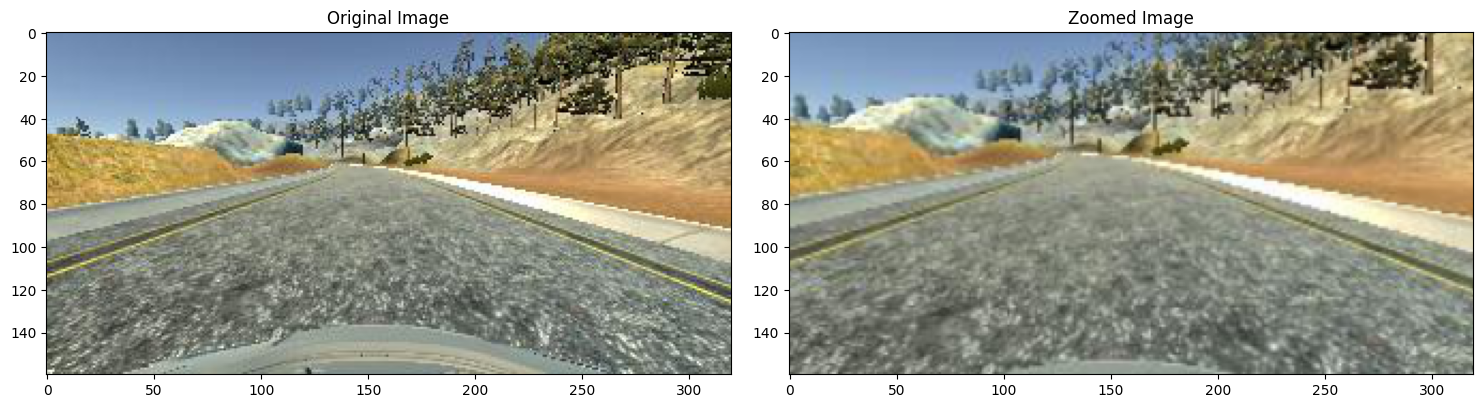

In [49]:
# Se realiza procesamiento de zoom para enfocar región de interés

# Se define función para aplicar zoom
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

# Ejemplo de aplicación de función en una imagen aleatoria
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

# Visualización de imágen original vs imagen modificada
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

**Image Aumentation 2 - Panning**

Text(0.5, 1.0, 'Panned Image')

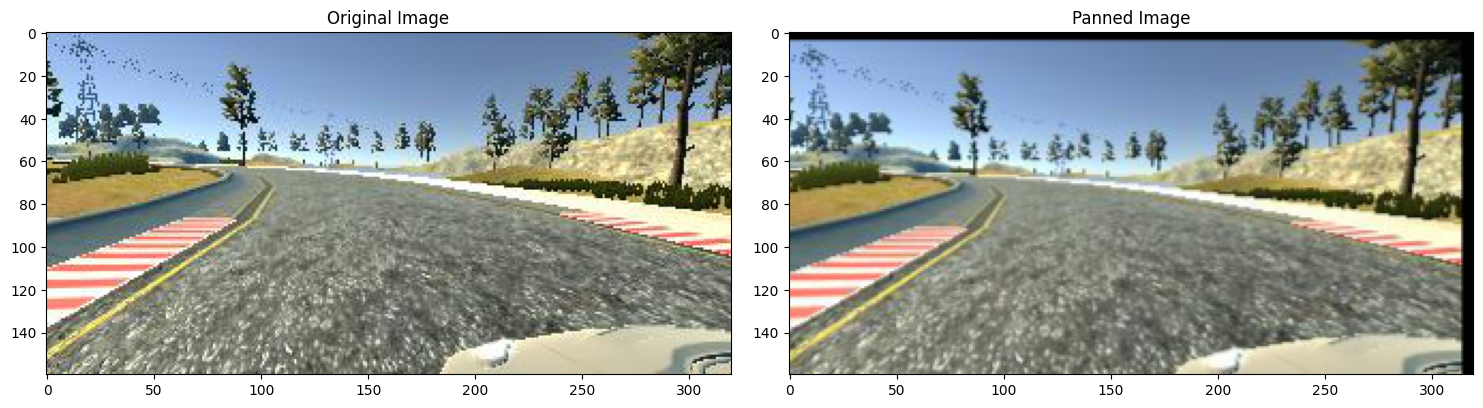

In [53]:
# Se define función para aplicar paneo aleatorio
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y":(-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

# Ejemplo de aplicación de función en una imagen aleatoria
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

# Visualización de imágen original vs imagen modificada
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

**Image Aumentation 3 - Brightness**

Text(0.5, 1.0, 'Brightness altered image ')

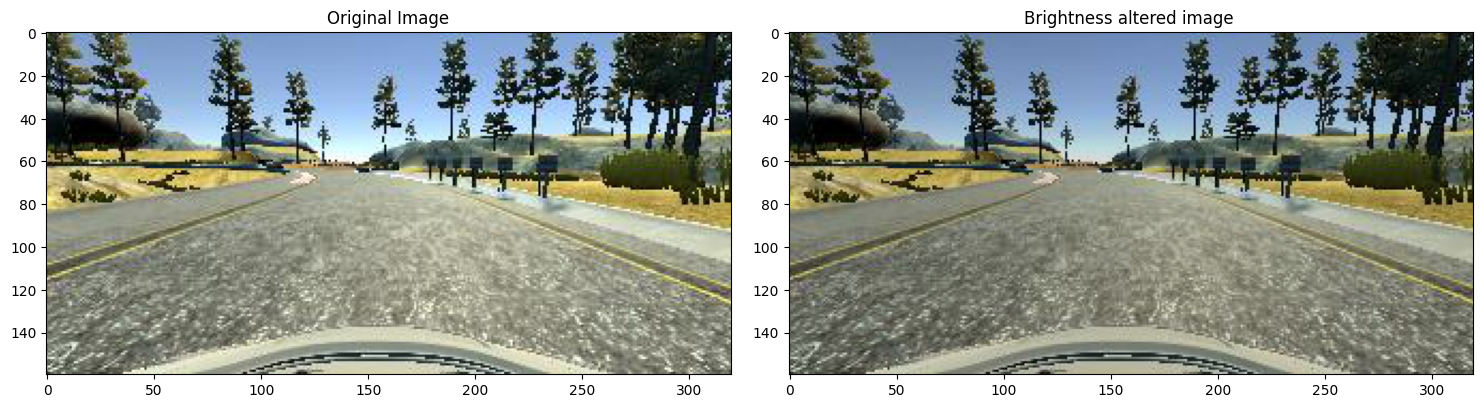

In [58]:
# Se define función para aplicar modificación de brillo aleatorio
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

# Ejemplo de aplicación de función en una imagen aleatoria
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

# Visualización de imágen original vs imagen modificada
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

**Image Aumentation 4 - Horizontal and Vertical Flip**

### Preparación de Red Neuronal

### **Conclusiones**

### Video Resumen

### **Referencias**